In [ ]:
# @title
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

/home/tifzaki/miniconda3/envs/zero_shot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 1
Seed set to 1
/home/tifzaki/miniconda3/envs/zero_shot/lib/python3.12/site-packages/neuralforecast/common/_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precis

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 57.71it/s, v_num=20, train_loss_step=139.0, train_loss_epoch=139.0] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 53.67it/s, v_num=20, train_loss_step=139.0, train_loss_epoch=139.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
------------------------------------------------

Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 51.25it/s, v_num=21, train_loss_step=142.0, train_loss_epoch=142.0] 

`Trainer.fit` stopped: `max_steps=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 47.49it/s, v_num=21, train_loss_step=142.0, train_loss_epoch=142.0]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 321.33it/s]
NBEATS WQL (0.5): 99.00
NBEATS MASE: 7.32
NHITS WQL (0.5): 97.96
NHITS MASE: 7.24


/home/tifzaki/miniconda3/envs/zero_shot/lib/python3.12/site-packages/neuralforecast/core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


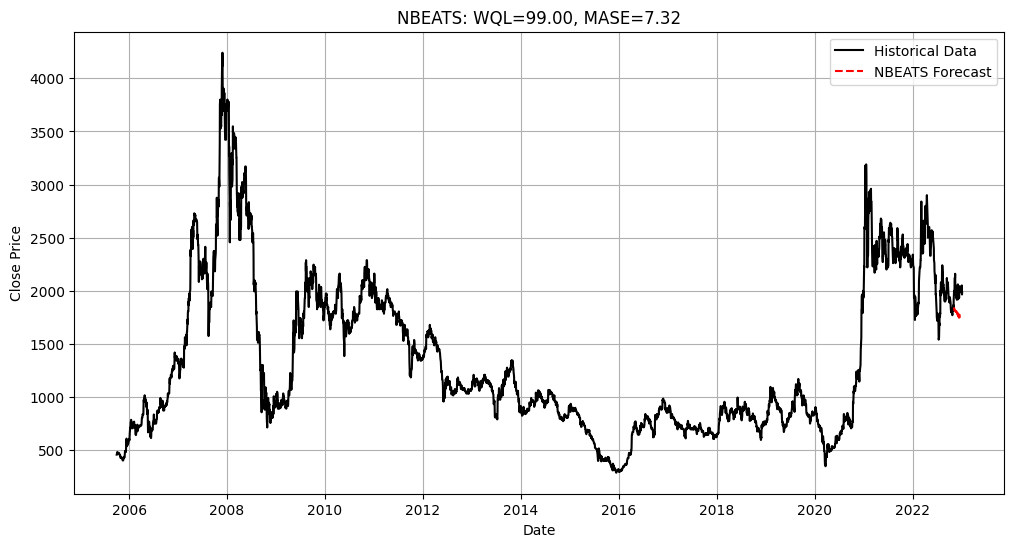

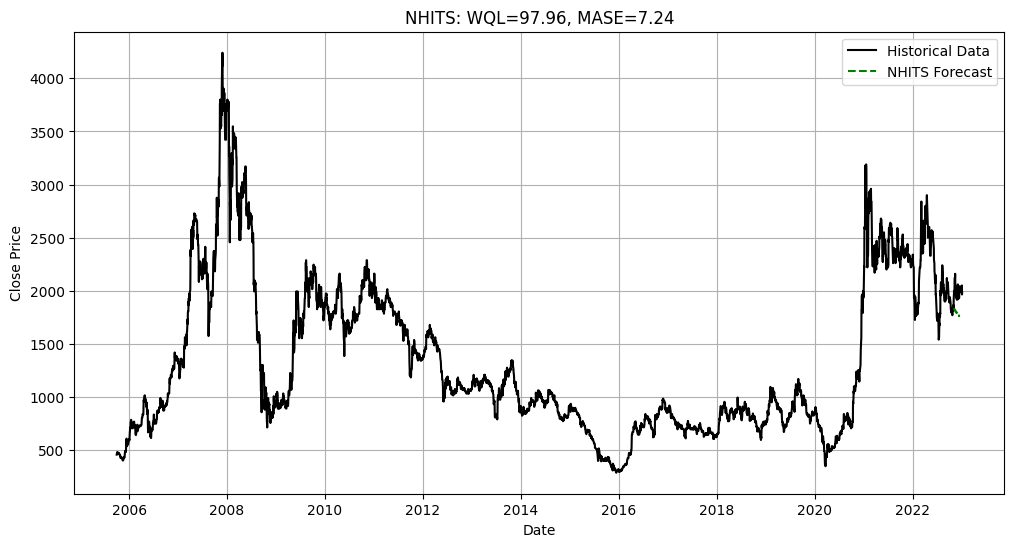

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load data
df = pd.read_csv('/home/tifzaki/dataset/LQ45-daily/ANTM.csv')
df = df.drop(df.index[:1164])
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Prepare data for forecasting
df['unique_id'] = 'Reliance'  # Unique identifier for the time series
df = df.rename(columns={"timestamp": "ds", "close": "y"})  # Rename columns
df = df[["unique_id", "ds", "y"]]  # Select only necessary columns

# Split dataset into train and test
train_size = int(len(df) * 0.99)
Y_train_df = df.iloc[:train_size]
Y_test_df = df.iloc[train_size:]

# Step 1: Predict with NeuralForecast (NBEATS & NHITS)
horizon = len(Y_test_df)
models = [
    NBEATS(input_size=2 * horizon, h=horizon, max_steps=50),
    NHITS(input_size=2 * horizon, h=horizon, max_steps=50)
]

nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df)  # This will use the CPU by default if no GPU is available
Y_hat_df = nf.predict().reset_index()

# Merge predictions with actuals
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
Y_hat_df = Y_hat_df.dropna()

# Define evaluation metrics
def weighted_quantile_loss(y_true, y_pred, quantile):
    residual = y_true - y_pred
    loss = np.where(residual > 0, quantile * residual, (quantile - 1) * residual)
    return np.mean(loss)

def mean_absolute_scaled_error(y_true, y_pred, y_train, seasonality=1):
    n = len(y_train)
    d = np.sum(np.abs(np.diff(y_train, n=seasonality)))
    errors = np.abs(y_true - y_pred)
    return errors.mean() / (d / (n - seasonality))

# Calculate WQL and MASE for NBEATS
wql_nbeats = weighted_quantile_loss(Y_hat_df['y'].values, Y_hat_df['NBEATS'].values, quantile=0.5)
mase_nbeats = mean_absolute_scaled_error(Y_hat_df['y'].values, Y_hat_df['NBEATS'].values, Y_train_df['y'].values)

# Calculate WQL and MASE for NHITS
wql_nhits = weighted_quantile_loss(Y_hat_df['y'].values, Y_hat_df['NHITS'].values, quantile=0.5)
mase_nhits = mean_absolute_scaled_error(Y_hat_df['y'].values, Y_hat_df['NHITS'].values, Y_train_df['y'].values)

# Print evaluation metrics
print(f"NBEATS WQL (0.5): {wql_nbeats:.2f}")
print(f"NBEATS MASE: {mase_nbeats:.2f}")
print(f"NHITS WQL (0.5): {wql_nhits:.2f}")
print(f"NHITS MASE: {mase_nhits:.2f}")

# Plot historical and forecasted data for NBEATS
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(Y_hat_df['ds'], Y_hat_df['NBEATS'], label='NBEATS Forecast', linestyle='--', color='red')
plt.title(f'NBEATS: WQL={wql_nbeats:.2f}, MASE={mase_nbeats:.2f}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot historical and forecasted data for NHITS
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(Y_hat_df['ds'], Y_hat_df['NHITS'], label='NHITS Forecast', linestyle='--', color='green')
plt.title(f'NHITS: WQL={wql_nhits:.2f}, MASE={mase_nhits:.2f}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


/home/tifzaki/miniconda3/envs/zero_shot/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ChronosPipeline WQL (0.5): 0.02
ChronosPipeline MASE: 3.51
ChronosPipeline MAE: 94.99
ChronosPipeline MAPE: 4.72%


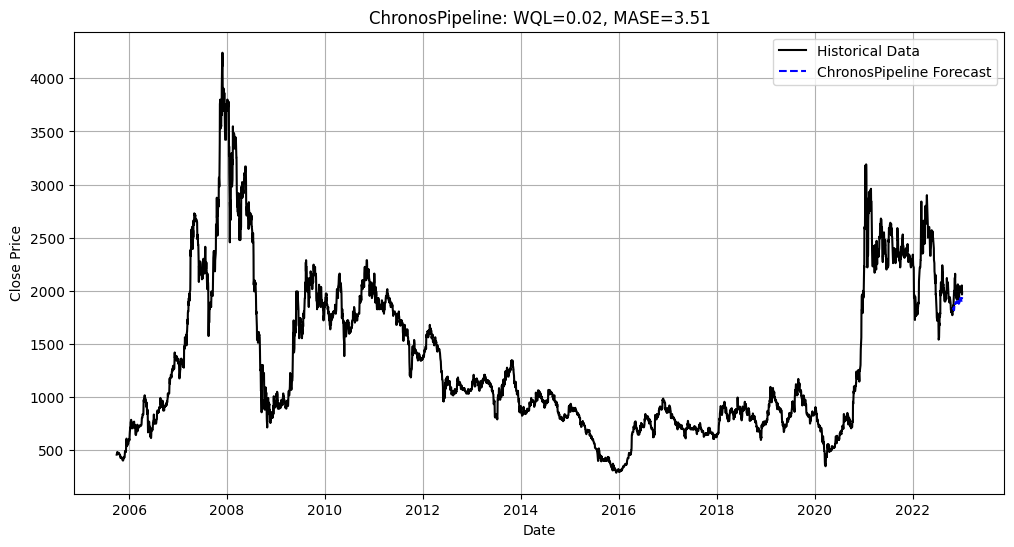

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from chronos import ChronosPipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load data
df = pd.read_csv('/home/tifzaki/dataset/LQ45-daily/ANTM.csv')
df = df.drop(df.index[:1164])
df['timestamp'] = pd.to_datetime(df['timestamp'])


# Prepare data for forecasting
df['unique_id'] = 'Reliance'  # Unique identifier for the time series
df = df.rename(columns={"timestamp": "ds", "close": "y"})  # Rename columns
df = df[["unique_id", "ds", "y"]]  # Select only necessary columns

# Split dataset into train and test
train_size = int(len(df) * 0.989)
Y_train_df = df.iloc[:train_size]
Y_test_df = df.iloc[train_size:]

# Step 1: Predict with ChronosPipeline
context_data = torch.tensor(Y_train_df['y'].values, dtype=torch.float32)

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda",  # Switch to "cpu"
    torch_dtype=torch.float32,
)

prediction_length = len(Y_test_df)
forecast = pipeline.predict(
    context=context_data,
    prediction_length=prediction_length,
    num_samples=20,
    limit_prediction_length=False
)

forecast_mean = forecast.mean(dim=1).squeeze().numpy()

# Calculate evaluation metrics for ChronosPipeline
mae_chronos = mean_absolute_error(Y_test_df['y'], forecast_mean)
mape_chronos = mean_absolute_percentage_error(Y_test_df['y'], forecast_mean)

# Define Weighted Quantile Loss (WQL) and Mean Absolute Scaled Error (MASE)
def weighted_quantile_loss(y_true, y_pred, quantile):
    errors = (y_true - y_pred)
    losses = np.where(errors > 0, quantile * errors, (1 - quantile) * np.abs(errors))
    return np.sum(losses) / np.sum(np.abs(y_true))


def mean_absolute_scaled_error(y_true, y_pred, y_train, seasonality=1):
    n = len(y_train)
    d = np.sum(np.abs(np.diff(y_train, n=seasonality)))
    errors = np.abs(y_true - y_pred)
    return errors.mean() / (d / (n - seasonality))

# Calculate WQL and MASE for ChronosPipeline
wql_chronos = weighted_quantile_loss(Y_test_df['y'].values, forecast_mean, quantile=0.5)
mase_chronos = mean_absolute_scaled_error(Y_test_df['y'].values, forecast_mean, Y_train_df['y'].values)

# Print evaluation metrics
print(f"ChronosPipeline WQL (0.5): {wql_chronos:.2f}")
print(f"ChronosPipeline MASE: {mase_chronos:.2f}")
print(f"ChronosPipeline MAE: {mae_chronos:.2f}")
print(f"ChronosPipeline MAPE: {mape_chronos:.2%}")

# Plot historical and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(Y_test_df['ds'], forecast_mean, label='ChronosPipeline Forecast', linestyle='--', color='blue')
plt.title(f'ChronosPipeline: WQL={wql_chronos:.2f}, MASE={mase_chronos:.2f}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


ChronosPipeline MAE: 108.99
ChronosPipeline MAPE: 5.41%


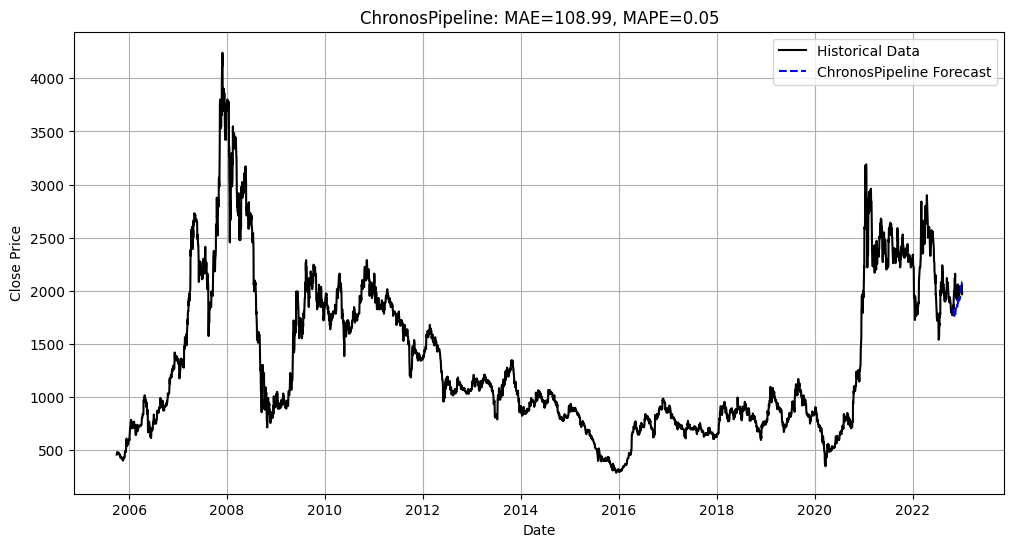

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from chronos import ChronosPipeline
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Load data
df = pd.read_csv('/home/tifzaki/dataset/LQ45-daily/ANTM.csv')
df = df.drop(df.index[:1164])
df['timestamp'] = pd.to_datetime(df['timestamp'])


# Prepare data for forecasting
df['unique_id'] = 'Reliance'  # Unique identifier for the time series
df = df.rename(columns={"timestamp": "ds", "close": "y"})  # Rename columns
df = df[["unique_id", "ds", "y"]]  # Select only necessary columns

# Split dataset into train and test
train_size = int(len(df) * 0.989)
Y_train_df = df.iloc[:train_size]
Y_test_df = df.iloc[train_size:]

# Step 1: Predict with ChronosPipeline
context_data = torch.tensor(Y_train_df['y'].values, dtype=torch.float32)

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # Switch to "cpu"
    torch_dtype=torch.float32,
)

prediction_length = len(Y_test_df)
forecast = pipeline.predict(
    context=context_data,
    prediction_length=prediction_length,
    num_samples=20,
    limit_prediction_length=False
)

forecast_mean = forecast.mean(dim=1).squeeze().numpy()

# Calculate evaluation metrics for ChronosPipeline
mae_chronos = mean_absolute_error(Y_test_df['y'], forecast_mean)
mape_chronos = mean_absolute_percentage_error(Y_test_df['y'], forecast_mean)


# Print evaluation metrics
print(f"ChronosPipeline MAE: {mae_chronos:.2f}")
print(f"ChronosPipeline MAPE: {mape_chronos:.2%}")

# Plot historical and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='Historical Data', color='black')
plt.plot(Y_test_df['ds'], forecast_mean, label='ChronosPipeline Forecast', linestyle='--', color='blue')
plt.title(f'ChronosPipeline: MAE={mae_chronos:.2f}, MAPE={mape_chronos:.2f}')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [9]:

import pandas as pd
from scipy.stats import gmean  # requires: pip install scipy


def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df.drop("model", axis="columns") / baseline_df.drop(
        "model", axis="columns"
    )
    return relative_score.agg(gmean)


result_df = pd.read_csv("/home/tifzaki/chronos-forecasting/scripts/evaluation/results/chronos-t5-small-zero-shot.csv").set_index("dataset")
baseline_df = pd.read_csv("/home/tifzaki/chronos-forecasting/scripts/evaluation/results/seasonal-naive-zero-shot.csv").set_index("dataset")

agg_score_df = agg_relative_score(result_df, baseline_df)
print(agg_score_df)

MASE   NaN
WQL    NaN
dtype: float64
